In [1]:
import pydicom
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
from os import walk
PathDicom = '../data/Pointrobotics/ImageDB/Image_20180509/Case2/CT/S6220/S2020_TH1_Gap0.8/'
lstFilesDCM = []
# get all file name in a directory
for (dirpath, dirnames, filenames) in walk(PathDicom):
    #print(filenames)
    lstFilesDCM.extend(filenames)
    break

lstFilesDCM = sorted(lstFilesDCM, key=lambda path: int(path[1:]))
print(lstFilesDCM)

for i in range(len(lstFilesDCM)):
    lstFilesDCM[i] = PathDicom + lstFilesDCM[i]

['I10', 'I20', 'I30', 'I40', 'I50', 'I60', 'I70', 'I80', 'I90', 'I100', 'I110', 'I120', 'I130', 'I140', 'I150', 'I160', 'I170', 'I180', 'I190', 'I200', 'I210', 'I220', 'I230', 'I240', 'I250', 'I260', 'I270', 'I280', 'I290', 'I300', 'I310', 'I320', 'I330', 'I340', 'I350', 'I360', 'I370', 'I380', 'I390', 'I400', 'I410', 'I420', 'I430', 'I440', 'I450', 'I460', 'I470', 'I480', 'I490', 'I500', 'I510', 'I520', 'I530', 'I540', 'I550', 'I560', 'I570', 'I580', 'I590', 'I600', 'I610', 'I620', 'I630', 'I640', 'I650', 'I660', 'I670', 'I680', 'I690', 'I700', 'I710', 'I720', 'I730', 'I740', 'I750', 'I760', 'I770', 'I780', 'I790', 'I800', 'I810', 'I820', 'I830', 'I840', 'I850', 'I860', 'I870', 'I880', 'I890', 'I900', 'I910', 'I920', 'I930', 'I940', 'I950', 'I960', 'I970', 'I980', 'I990', 'I1000', 'I1010', 'I1020', 'I1030', 'I1040', 'I1050', 'I1060', 'I1070', 'I1080', 'I1090', 'I1100', 'I1110', 'I1120', 'I1130', 'I1140', 'I1150', 'I1160', 'I1170', 'I1180', 'I1190', 'I1200', 'I1210', 'I1220', 'I1230', 

In [3]:
# Get ref file
RefDs = pydicom.read_file(lstFilesDCM[0], force=True)
print(RefDs)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20171205'
(0008, 0013) Instance Creation Time              TM: '154005.660'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.46.670589.33.1.63648085205654655100001.4702291070137030256
(0008, 0020) Study Date                          DA: '20171205'
(0008, 0021) Series Date                         DA: '20171205'
(0008, 0022) Acquisition Date                    DA: '20171205'
(0008, 0023) Content Date                        DA: '20171205'
(0008, 002a) Acquisition DateTime                DT: '20171205023925.050'
(0008, 0030) Study Time                          TM: '153723.961'
(0008, 0031) Series Time                         TM: '153940.221'
(0008, 0032) Acquisition Time                    TM: '153925'
(0008, 0

In [4]:
# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
print (ConstPixelDims)
# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
print (ConstPixelSpacing)


(512, 512, 502)
(0.46484375, 0.46484375, 1.0)


(502, 512, 512)


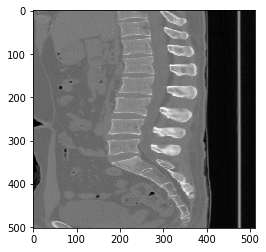

In [77]:
size = ConstPixelDims[0]
data_shape = (len(lstFilesDCM), size, size)
x = np.zeros(data_shape)

i = 0
# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # file name
    filename = filenameDCM.split('/')[-1]
    # read the file
    ds = pydicom.read_file(filenameDCM)
    # store the raw image data
    img = ds.pixel_array

    x[i,:,:] = img
    i += 1
    
print(x.shape)
plt.imshow(x[:,:,int(x.shape[2]/2)], cmap='gray')

1.0


In [78]:
# resize the 3d image
from scipy.ndimage import zoom
# from sklearn.preprocessing import normalize

# norm1 = x / np.linalg.norm(x)

scale = 1

x = zoom(x, (
    ConstPixelSpacing[2] * scale,
    ConstPixelSpacing[1] * scale,
    ConstPixelSpacing[0] * scale))

print(x.shape, x.max())

(502, 238, 238) 4548.343446464902


In [2]:
# save tmp data

#np.save('./tmp/point-test.npy', x)
x = np.load('./tmp/point-test.npy')
#data_shape = (512, 512, 134)
#data_shape = (502, 238, 238)
data_shape = x.shape

In [3]:
from scipy import ndimage

x_original = x

x_original = (x_original - x_original.min())/(x_original.max() - x_original.min())

# def windowing(img):
#     window_width, window_level = 1800, 400
#     upper, lower = window_level + window_width / 2, window_level - window_width / 2
#     img = np.clip(img,lower,upper)
#     img = (img - lower) / window_width
#     return img

def windowing(img, lower, upper):
    
    slope = 1
    intercept = -1024
    img = img * slope + intercept

    img = np.clip(img,lower,upper)
    img = (img - lower) / (upper - lower)
    
    return img

def sobel3d(input_img):
    
    x = ndimage.sobel(input_img, 0)
    y = ndimage.sobel(input_img, 1)
    z = ndimage.sobel(input_img, 2)
    
    output_img = x + y + z
    
    output_img = np.absolute(output_img)
    
    output_img = (output_img - output_img.min()) / (output_img.max() - output_img.min())
    
    return output_img

x = windowing(x, 100, 1000)
x = sobel3d(x)

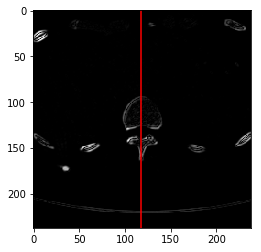

In [5]:
z = 118
plt.plot((z, z), (0, data_shape[1]), '-', color='red')
plt.imshow(x[50,:,:], cmap='gray')

True

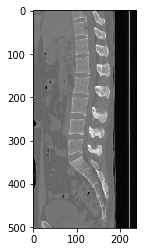

In [6]:
plt.imshow(x_original[:,:,z], cmap='gray')
cv2.imwrite('../darknet/data/ian/test/script_point.png', x_original[:,:,z] * 255)

In [13]:
# YOLO predict

import subprocess
import os

origin_dir = os.getcwd()
os.chdir('../darknet')

#cmdstr = './darknet detector test cfg/ian.data cfg/yolov3-ian.cfg backup/yolov3-ian_50000.weights data/ian/test/case1_97.jpg'
cmdstr = './darknet detector test cfg/ian.data cfg/yolov3-ian.cfg backup/yolov3-ian_last.weights -dont_show -ext_output < {} > {} -i {}'.format(
    'data/ian/test/script_point.txt',
    'data/ian/test/script_point_result.txt',
    '0')# GPU
print(cmdstr)

detect_result = subprocess.check_output(cmdstr, shell = True)

os.chdir(origin_dir)

print(detect_result)
print('== YOLO pedicted ==')

./darknet detector test cfg/ian.data cfg/yolov3-ian.cfg backup/yolov3-ian_last.weights -dont_show -ext_output < data/ian/test/script_point.txt > data/ian/test/script_point_result.txt -i 0
b''
== YOLO pedicted ==


In [14]:
# Load YOLO predict result

import re

yolo_results = []

with open('../darknet/data/ian/test/script_point_result.txt', 'r') as f:
    content = f.read().split('Enter Image Path:')
    print(content)
    result = content[1].split('\n')
    del result[0], result[-1]
    
    for line in result:
        yolo_results.append({
            'label': line.split(':')[0],
            #'confidence': int(re.sub("\D", "", line.split('%')[0].split(':')[1])),
            'left_x': int(re.sub("\D", "", line.split(':')[2])),
            'top_y': int(re.sub("\D", "", line.split(':')[3])),
            'center_x': int(int(re.sub("\D", "", line.split(':')[2])) + int(re.sub("\D", "", line.split(':')[4]))/2),
            'center_y': int(int(re.sub("\D", "", line.split(':')[3])) + int(re.sub("\D", "", line.split(':')[5]))/2),
            'w': int(re.sub("\D", "", line.split(':')[4])),
            'h': int(re.sub("\D", "", line.split(':')[5])),
        })

yolo_results = sorted(yolo_results, key=lambda r: r['center_y'])
        
# delete bad result
# for y in yolo_results:
#     if 100 > y['center_x'] or y['center_x'] > 120:
#         yolo_results.remove(y)
    
for i in yolo_results:
    print(i)

['Total BFLOPS 65.428 \n\n seen 64 \n', ' data/ian/test/script_point.png: Predicted in 682.751000 milli-seconds.\nvertebrae: 100%\t(left_x:   79   top_y:  296   width:   37   height:   41)\nvertebrae: 100%\t(left_x:   82   top_y:  247   width:   38   height:   46)\nvertebrae: 100%\t(left_x:   86   top_y:  199   width:   41   height:   46)\nvertebrae: 96%\t(left_x:   86   top_y:   -0   width:   40   height:   27)\nvertebrae: 100%\t(left_x:   93   top_y:   25   width:   37   height:   42)\nvertebrae: 100%\t(left_x:   93   top_y:  151   width:   38   height:   49)\nvertebrae: 100%\t(left_x:   97   top_y:   64   width:   34   height:   44)\nvertebrae: 100%\t(left_x:   98   top_y:  106   width:   35   height:   47)\n', ' \n: Predicted in 18.429000 milli-seconds.\n', ' ']
{'label': 'vertebrae', 'left_x': 86, 'top_y': 0, 'center_x': 106, 'center_y': 13, 'w': 40, 'h': 27}
{'label': 'vertebrae', 'left_x': 93, 'top_y': 25, 'center_x': 111, 'center_y': 46, 'w': 37, 'h': 42}
{'label': 'vertebrae',

W0416 14:50:26.880716 140348020033344 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0416 14:50:26.885539 140348020033344 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0416 14:50:26.888616 140348020033344 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all 

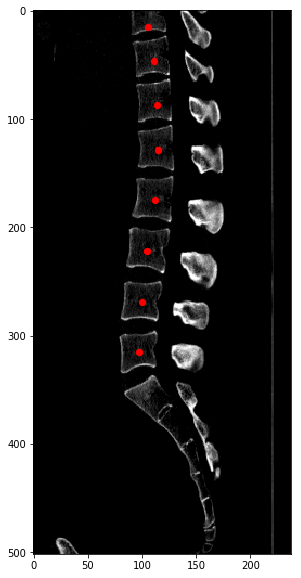

In [86]:
# Draw point
import numpy as np
import random

x_coords = []
y_coords = []
labels = []
for result in yolo_results:
    #print(result)
    x_coords.append(result['center_x'])
    y_coords.append(result['center_y'])
    labels.append(result['label'])
    

plt.figure(figsize=(10, 10))
plt.imshow(x[:,:,z], cmap='gray')

for i in range(len(x_coords)):
    #color = [1, 0 + random.random()/2, 0.5 + random.random()/2]
    x_coord, y_coord, label = x_coords[i], y_coords[i], labels[i]
    plt.scatter(x = x_coord, y = y_coord, c = [1,0,0], s = 40)
    #plt.text(x_coord + 15, y_coord, label, fontsize=16, color = color)

plt.show()

In [15]:
import keras
from keras import backend as K
import os
os.environ['KERAS_BACKEND']='tensorflow'
import h5py
import cv2
import matplotlib.pyplot as plt
import numpy as np
from os import walk
import random
import re

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

def setGPU():
    import tensorflow as tf
    tf.config.gpu.set_per_process_memory_growth(enabled=True)

setGPU()

print('libs loaded')

size = 128

Using TensorFlow backend.


libs loaded


In [16]:
from model3d import Deeplabv3

deeplab_model = Deeplabv3(
    input_shape=(128, 128, 128, 1),
    classes=1,
    weights=None,
    backbone = 'xception',
    activation='sigmoid')

def load_weights():
#     weight_path = '../keras-deeplab-v3-plus/save/model.3dxceptionwindow0416.weights.last.h5'
    weight_path = '../keras-deeplab-v3-plus/save/model.sobel0504.weights.last.h5'
    file=h5py.File(weight_path,'r')
    weight = []
    for i in range(len(file.keys())):
        weight.append(file['weight'+str(i)][:])
    deeplab_model.set_weights(weight)

load_weights()

(None, 32, 32, 32, 1)


In [17]:

def model2():
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Concatenate, BatchNormalization, Activation, Dense, Flatten
    
    def conv(input_tensor, depth):
        conv_tensor = Conv3D(depth, 3, padding = 'same', kernel_initializer = 'he_normal')(input_tensor)
        bn = BatchNormalization()(conv_tensor) # use_bias=False
        output_tensor = Activation('relu')(bn)
        return output_tensor
    
    def pool(input_tensor):
        output_tensor = MaxPooling3D(pool_size=(2, 2, 2))(input_tensor)
        return output_tensor
    
    def up(input_tensor):
        output_tensor = UpSampling3D(size=(2, 2, 2))(input_tensor)
        return output_tensor
    
    def skip(input_tensor1, input_tensor2):
        output_tensor = Concatenate(axis=-1)([input_tensor1, input_tensor2])
        return output_tensor
    
    input_img = Input(shape=(size, size, size, 1))
    
    conv1 = conv(input_img, 8)
    conv2 = conv(conv1, 8)
    
    pool1 = pool(conv2)
    
    conv3 = conv(pool1, 16)
    conv4 = conv(conv3, 16)
    
    pool2 = pool(conv4)
    
    conv5 = conv(pool2, 32)
    conv6 = conv(conv5, 32)
    
    pool3 = pool(conv6)
    
    conv7 = conv(pool3, 64)
    conv8 = conv(conv7, 64)

    pool4 = pool(conv8)
    
    conv9 = conv(pool4, 128)
    conv10 = conv(conv9, 128)
    
    flat = Flatten()(conv10)
    
    dense1 = Dense(units = 1024, activation = 'relu')(flat)
    
    dense2 = Dense(units = 1024, activation = 'relu')(flat)
    
    output_cat = Dense(units = 20, activation = 'softmax')(dense1)

    
    # model
    model = Model(inputs=input_img, outputs=output_cat)
    print (model.output_shape)
    
    return model



model2 = model2()
model2.load_weights('../segmentation/save/model.label.weights.best.h5')

# from xception3d import Xception

# size = 128

# model2 = Xception(
#     input_shape = (size, size, size, 1),
#     classes = 20
# )

# model2.load_weights('../segmentation/save/model.xception0419.weights.last.h5')

(None, 20)


In [18]:
def image_histogram_equalization(image, number_bins=256):
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape), cdf

def generate_seg_result(vertebrae):
    # generate segmentation test data .npy
    shape = x.shape

    #vertebrae = {'label': 'T8', 'left_x': 65, 'top_y': 154, 'center_x': 98, 'center_y': 187, 'w': 67, 'h': 67}

    center_x, center_y = vertebrae['center_x'], vertebrae['center_y']

    size = 128 # patch size = size*size*size
    min_x, max_x, min_y, max_y = center_x - size/2, center_x + size/2, center_y - size/2, center_y + size/2

    range_x = [
        int(min_x if min_x > 0 else 0),
        int(max_x if max_x < (shape[1] - 1) else (shape[1] - 1))
    ]
    range_y = [
        int(min_y if min_y > 0 else 0),
        int(max_y if max_y < (shape[0] - 1) else (shape[0] - 1))
    ]
    range_z = [
        int(z - size/2),
        int(z + size/2)
    ]
    #print(range_x)
    #print(range_y)
    #print(center_x)

    padding_y = (
    int(size/2) - center_y + range_y[0],
    int(size/2) - range_y[1] + center_y
    )
    padding_x = (
        int(size/2) - center_x + range_x[0],
        int(size/2) - range_x[1] + center_x
    )

    out_x = np.pad(
        x[
            range_y[0]: range_y[1]
            , range_x[0]: range_x[1]
            , range_z[0]: range_z[1]],
        (padding_y, padding_x, (0, 0)),
        'constant') #/ 255
    
    #out_x = (out_x - out_x.min()) / (out_x.max() - out_x.min())
    
    #out_x = out_x * 255
    
    #out_x = image_histogram_equalization(out_x.astype(int))[0] / 255

    plt.imshow(out_x[:,:,64], cmap='gray')
    #np.save('./tmp/seg_test_data/{}.npy'.format(vertebrae['label']), out_x)
    
    out_x = np.reshape(out_x, (1, 128, 128, 128, -1))
    
    print(out_x.max())
    
    out_y = deeplab_model.predict(out_x)
    
    out_y = np.reshape(out_y, (128, 128, 128))
    
    #plt.imshow(out_y[:,:,z], cmap='gray')
    
    return out_y

0.9356446806330306


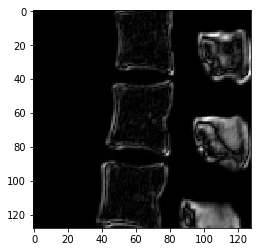

In [19]:
# combine seg result

combine_result = np.zeros(x.shape)

vertebrae = yolo_results[4]
seg_result = generate_seg_result(vertebrae)

#plt.imshow(seg_result[:,:,z], cmap='gray')

(128, 128, 128)


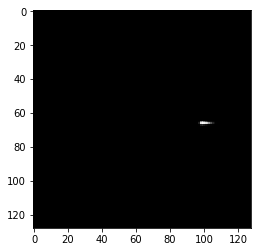

In [20]:
plt.imshow(seg_result[:,:,64], cmap='gray')
print(seg_result.shape)

0.8706283798625805
0.8739912690410683
0.925837003770758
0.9356446806330306
0.9356446806330306
0.9400137515451865
0.9423048833116631
0.9484001934643573


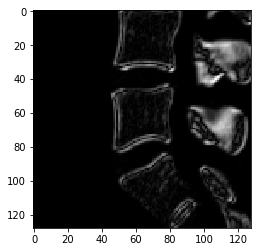

In [21]:
# combine
size = 128
seg_results = np.zeros((len(yolo_results) ,size, size, size))
label_results = []

for i in range(len(yolo_results)):
    seg_result = generate_seg_result(yolo_results[i])
    #plt.imshow(seg_result[:,:,60] > 0.5, cmap='gray')
    seg_results[i] = seg_result
    
    label_result = model2.predict(np.reshape(seg_result, (1, 128, 128, 128, -1)))[0]
    label_results.append(label_result)

In [22]:
#print(label_results)
for label_result in label_results:
    print('label {} \t confidence {}'.format(np.argmax(label_result), max(label_result)))

label 6 	 confidence 0.34918391704559326
label 6 	 confidence 0.3300319015979767
label 11 	 confidence 0.14576752483844757
label 11 	 confidence 0.1389474868774414
label 9 	 confidence 0.18435145914554596
label 3 	 confidence 0.14071907103061676
label 11 	 confidence 0.12166667729616165
label 1 	 confidence 0.14740300178527832


In [23]:
n_of_vertebrae = len(yolo_results)
confidences = [] # conf of labels start from


for i in range(20): # label start from
    sum_of_confidences = 0
    for n in range(n_of_vertebrae):
        #print(label_results[n][(i + n) % 20])
        sum_of_confidences += label_results[n][(i + n) % 20]
    #print(sum_of_confidences / 20)
    confidences.append(sum_of_confidences / 20)
    print('{} \t as head, average confidence {}'.format(i, sum_of_confidences / 20))

head = np.argmax(confidences)
print()
print('Result: choose {} as head'.format(head))
print('From {} to {}'.format(head, head + n_of_vertebrae -1))

0 	 as head, average confidence 0.017434809322003274
1 	 as head, average confidence 0.023969439696520566
2 	 as head, average confidence 0.02134321369230747
3 	 as head, average confidence 0.02400841284543276
4 	 as head, average confidence 0.032220080494880676
5 	 as head, average confidence 0.052401679754257205
6 	 as head, average confidence 0.040523205138742927
7 	 as head, average confidence 0.02355363864917308
8 	 as head, average confidence 0.020298741385340692
9 	 as head, average confidence 0.016202042740769685
10 	 as head, average confidence 0.01085021891631186
11 	 as head, average confidence 0.0052626347867771985
12 	 as head, average confidence 0.006481539900414645
13 	 as head, average confidence 0.005872435466153547
14 	 as head, average confidence 0.0130487863367307
15 	 as head, average confidence 0.011399787111440674
16 	 as head, average confidence 0.016242656190297567
17 	 as head, average confidence 0.018868794193258508
18 	 as head, average confidence 0.01875343

In [24]:
# generate final result
# (559, 160, 160)
import random

final_result = np.zeros((x.shape[0] + size, x.shape[1] + size, x.shape[2] + size)) # 64 padding
final_result_colored = np.zeros((x.shape[0] + size, x.shape[1] + size, x.shape[2] + size, 3)) # colored

for i in range(len(yolo_results)):
    
    x_start = yolo_results[i]['center_x'] - 64 + 64
    x_end = yolo_results[i]['center_x'] + 64 + 64
    
    y_start = yolo_results[i]['center_y'] - 64 + 64
    y_end = yolo_results[i]['center_y'] + 64 + 64
    
    result = np.zeros((x.shape[0] + size, x.shape[1] + size, x.shape[2] + size))
    result[y_start:y_end, x_start:x_end, (z - 64 + 64):(z + 64 + 64)] = seg_results[i][:, :, :] > 0.5 # (y, x, z)
    
    final_result[np.where(result > 0.5)] = 1
    final_result_colored[np.where(result > 0.5)] = [
        (1 if i%2 == 0 else 0.5),
        random.random()/2 + 0.5,
        (0.5 if i%2 == 0 else 1)]
    
#     for p in range(0, size):
#         for q in range(0, size):
#             for r in range(0, size):
#                 if seg_results[i][p, q, r] > 0.5:
#                     final_result[p + 64, q + 64, r + 64] = 1
    
final_result = final_result[
    int(size/2): x.shape[0] + int(size/2),
    int(size/2): x.shape[1] + int(size/2),
    int(size/2): x.shape[2] + int(size/2)]
final_result_colored = final_result_colored[
    int(size/2): x.shape[0] + int(size/2),
    int(size/2): x.shape[1] + int(size/2),
    int(size/2): x.shape[2] + int(size/2)]

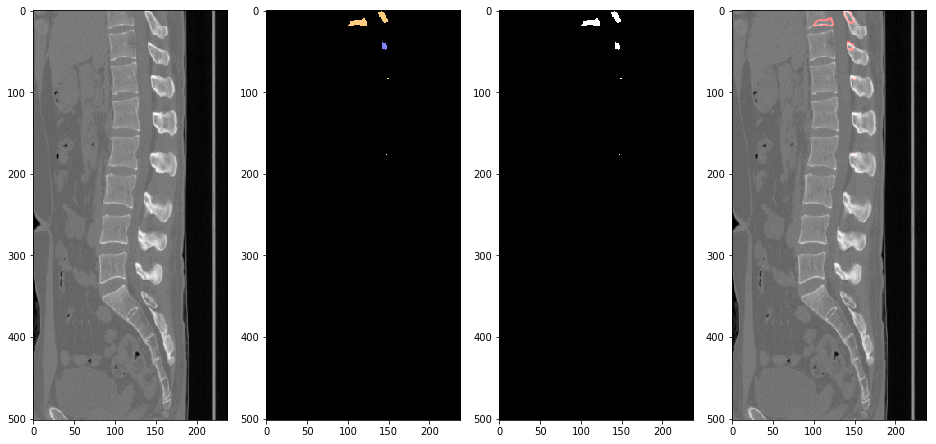

In [25]:
def contour_result(x, mask):    
    def sobel(img):
        x = cv2.Sobel(img,cv2.CV_16S,1,0)
        y = cv2.Sobel(img,cv2.CV_16S,0,1)
        absX = cv2.convertScaleAbs(x)
        absY = cv2.convertScaleAbs(y)
        dst = cv2.addWeighted(absX,0.5,absY,0.5,0)
        dst = np.where(dst > 0, 1.0, 0)
        return dst
    contour = sobel(mask)
    original = np.stack((x/255,)*3, axis=-1)
    original = (original - original.min())/(original.max() - original.min())
    red_contour = np.stack((contour, np.zeros(contour.shape), np.zeros(contour.shape)), axis=-1)
    contour_conbine = np.where(red_contour > 0, red_contour, original)
    return contour_conbine

plt.figure(figsize=(16, 12))
plt.subplot(141)
plt.imshow(x_original[:,:,z], cmap='gray')
plt.subplot(142)
plt.imshow(final_result_colored[:,:,z,:])
plt.subplot(143)
plt.imshow(final_result[:,:,z], cmap='gray')
plt.subplot(144)
plt.imshow(contour_result(x_original[:,:,z], final_result[:,:,z]))

In [25]:
path = './show_colored_point_deeplab3d_window2'

#os.makedirs(path)

for i in range(x.shape[2]):
    cv2.imwrite(path + '/{}.png'.format(i), final_result_colored[:,:,i] * 255)
    